In [1]:
import numpy as np
from pytorch_forecasting.data.examples import get_stallion_data

data = get_stallion_data()

data["id"] = (data["agency"].astype(str) + "_" + data["sku"].astype(str)).astype("category")

# add time index
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()

# add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

data["sku_int"] = data["sku"].cat.codes.astype(int)
data["agency_int"] = data["agency"].cat.codes.astype(int)

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data["new_year_int"] = data["new_year"].cat.codes.astype(int)

In [2]:
# :
# max_prediction_length = 6
# max_encoder_length = 24
# training_cutoff = data["time_idx"].max() - max_prediction_length

# training = a(
#     time_idx="time_idx",
#     target="volume",
#     group_ids=["agency", "sku"],
#     min_encoder_length=0,  # allow encoder lengths from 0 to max_prediction_length
#     max_encoder_length=max_encoder_length,
#     max_prediction_length=max_prediction_length,
#     static_categoricals=["agency", "sku"],
#     static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
#     time_varying_known_categoricals=["special_days", "month"],
#     variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
#     time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
#     time_varying_unknown_categoricals=[],
#     time_varying_unknown_reals=["volume", "log_volume", "industry_volume", "soda_volume", "avg_max_temp", "avg_volume_by_agency", "avg_volume_by_sku"],
# )

In [3]:
max(len(data["agency_int"].unique()), len(data["sku_int"].unique()))

58

In [4]:
from tft_forecasting.model.utils import TSDataset

ds = TSDataset(
    id_col = "id", 
    static_cols = ["sku_int", "agency_int"], 
    time_col = "time_idx", 
    input_cols = ["industry_volume", "soda_volume", "avg_max_temp", "avg_volume_by_agency", "avg_volume_by_sku", "new_year_int", "discount_in_percent"],
    target_col = "volume", 
    time_steps = 59, 
    max_samples = 1000,
    input_size = 7, 
    encode_length = 40, 
    num_static = 2,
    output_size = 1, 
    data = data,
)

Getting valid sampling locations.
Max samples=1000 exceeds # available segments=700


/Users/thomaskientz/Documents/Documents - Thomas’s MacBook Pro/Github/tft-forecasting/tft_forecasting/model/utils.py:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for identifier, df in data.groupby(id_col):


In [5]:
from torch.utils.data import DataLoader

batch_size = 64
loader = DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=1,
    shuffle=True
)

In [6]:
from tft_forecasting import TFT

for batch in loader:
    break

model = TFT(
    batch_size=batch_size,
    static_variables=2,
    n_past_covariates=5,
    n_past_categorical_covariates=1,
    n_future_covariates=1,
    num_masked_series=5,
    embedding_dim=8,
    static_embedding_vocab_size=58,
    time_varying_embedding_vocab_size=2,
    encode_length=40,  # kind of like training size
    seq_length=59  # kind of like total size, and predicting window is seq_length - encode_length
)

(
    output,
    encoder_output,
    decoder_output,
    attn_output,
    attn_output_weights,
    encoder_sparse_weights,
    decoder_sparse_weights,
) = model.forward(batch)

In [7]:
(
    output,
    encoder_output,
    decoder_output,
    attn_output,
    attn_output_weights,
    encoder_sparse_weights,
    decoder_sparse_weights,
) = model.forward(batch)

<Axes: >

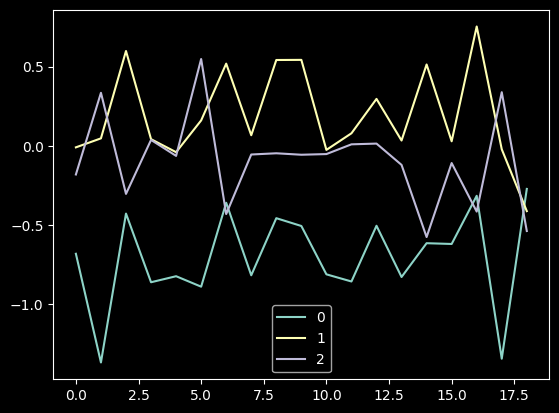

In [8]:
import pandas as pd

pd.DataFrame(output[0].detach().numpy()).plot()

In [9]:
import torch
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tft_forecasting.model.utils import QuantileLoss

# Quantile loss for multiple quantiles
q_loss_func = QuantileLoss([0.1, 0.5, 0.9])
batch_size = 64

# Dataset setup
ds = TSDataset(
    id_col="id", 
    static_cols=["sku_int", "agency_int"], 
    time_col="time_idx", 
    input_cols=["industry_volume", "soda_volume", "avg_max_temp", "avg_volume_by_agency", "avg_volume_by_sku", "new_year_int", "discount_in_percent"],
    target_col="volume", 
    time_steps=59, 
    max_samples=10000,
    input_size=7, 
    encode_length=40, 
    num_static=2,
    output_size=1, 
    data=data
)

# Splitting the dataset into training and validation sets
train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
train_dataset, val_dataset = random_split(ds, [train_size, test_size])

# DataLoaders for training and validation
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=1,
    shuffle=True,
    drop_last=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=1,
    shuffle=False,
    drop_last=True
)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Model training
model.train()
epochs = 40
training_losses = []
validation_losses = []

for epoch in range(epochs):
    epoch_training_losses = []
    epoch_validation_losses = []
    
    # Training phase
    for batch in train_loader:
        optimizer.zero_grad()
        (
            output,
            encoder_output,
            decoder_output,
            attn_output,
            attn_output_weights,
            encoder_sparse_weights,
            decoder_sparse_weights,
        ) = model(batch)
        loss = q_loss_func(output[:, :, :].view(-1, 3), batch['outputs'][:, :, 0].flatten().float())
        loss.backward()
        optimizer.step()
        epoch_training_losses.append(loss.item())

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for batch in val_loader:
            (
                output,
                encoder_output,
                decoder_output,
                attn_output,
                attn_output_weights,
                encoder_sparse_weights,
                decoder_sparse_weights,
            ) = model(batch)
            loss = q_loss_func(output[:, :, :].view(-1, 3), batch['outputs'][:, :, 0].flatten().float())
            epoch_validation_losses.append(loss.item())
    model.train()  # Set the model back to training mode

    # Logging the average losses
    avg_train_loss = np.mean(epoch_training_losses)
    avg_val_loss = np.mean(epoch_validation_losses)
    training_losses.append(avg_train_loss)
    validation_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")



Getting valid sampling locations.
Max samples=10000 exceeds # available segments=700


/Users/thomaskientz/Documents/Documents - Thomas’s MacBook Pro/Github/tft-forecasting/tft_forecasting/model/utils.py:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for identifier, df in data.groupby(id_col):


Epoch 1/40, Train Loss: 157.6931, Validation Loss: 177.3222
Epoch 2/40, Train Loss: 157.5994, Validation Loss: 177.3615
Epoch 3/40, Train Loss: 157.5435, Validation Loss: 177.3463
Epoch 4/40, Train Loss: 157.5083, Validation Loss: 177.3171
Epoch 5/40, Train Loss: 157.4849, Validation Loss: 177.3207
Epoch 6/40, Train Loss: 157.4673, Validation Loss: 177.3306
Epoch 7/40, Train Loss: 157.4530, Validation Loss: 177.3142
Epoch 8/40, Train Loss: 157.4403, Validation Loss: 177.3112
